In [1]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
import PolarTestingTrainingSplit_CV
from matplotlib.colors import LinearSegmentedColormap
from numpy.random import seed
seed(0)


# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/PoChedleyEtAl2022/TASmaps/*_TrendMaps.nc'
ModelNames = [i[70:-16] for i in glob.glob(path_to_data)]

# Get observational data
observational_trends = glob.glob('/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplication/TASObsTrends/*.npy')
observational_trend_maps = [np.load(observational_trends[i]) for i in range(0,len(observational_trends))]
latitudes = np.linspace(-88.75,88.75,72)
weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
observational_trend_maps_weighted = np.multiply(observational_trend_maps, weights[np.newaxis,:,np.newaxis])
observational_trend_maps_reshaped = np.reshape(observational_trend_maps_weighted, (3, 72*144))

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = PolarTestingTrainingSplit_CV.training_testing_split(path_to_data)


In [7]:
from keras.models import Sequential
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(0)

# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
gistemp_predictions = []
era5_predictions = []
hadcrut_predictions = []

#for param_set in conv_params:
predictions = []
validations = []

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=4e-5, restore_best_weights=True)

for model_idx in range(len(ModelNames)):
    # Reshape target and predictor data for model
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingTargetDataReshaped = np.reshape(TrainingTargetData[model_idx], (TrainingTargetDataShape[0], TrainingTargetDataShape[1]*TrainingTargetDataShape[2]))
    TestingTargetDataReshaped = np.reshape(TestingTargetData[model_idx], (TestinTargetDataShape[0], TestinTargetDataShape[1]*TestinTargetDataShape[2]))

    # Train model
    TrainingTargetDataReshaped = np.transpose([TrainingTargetDataReshaped[:,0], TrainingTargetDataReshaped[:,3]])
    

    # reshape predictor data
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingTargetDataReshaped = np.reshape(TrainingTargetData[model_idx], (TrainingTargetDataShape[0], TrainingTargetDataShape[1]*TrainingTargetDataShape[2]))
    TestingTargetDataReshaped = np.reshape(TestingTargetData[model_idx], (TestinTargetDataShape[0], TestinTargetDataShape[1]*TestinTargetDataShape[2]))
    TrainingTargetDataReshaped = np.transpose([TrainingTargetDataReshaped[:,0], TrainingTargetDataReshaped[:,3]])
    TrainingPredictorDataReshaped = np.reshape(TrainingPredictorData[model_idx], (len(TrainingPredictorData[model_idx]),72,144))
    TestingPredictorDataReshaped = np.reshape(TestingPredictorData[model_idx], (len(TestingPredictorData[model_idx]),72,144))


    num_filters = 72
    filter_size_1 = 3
    filter_size_2 = 1
    pool_size = 3

    model = models.Sequential()
    model.add(layers.Conv2D(num_filters, filter_size_1, activation='relu', input_shape=(72, 144, 1)))
    #model.add(layers.Conv2D(num_filters, filter_size_2, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size))
    model.add(layers.Flatten())
    model.add(layers.Dense(2))
    model.compile(loss="mse", optimizer=optimizers.Adam(learning_rate=1e-4))
    model.fit(TrainingPredictorDataReshaped, TrainingTargetDataReshaped, epochs=100, 
              verbose=1, validation_split=0.1, callbacks=[stop_early])
    
    # Predict using trained model
    Y_pred = model.predict(TestingPredictorDataReshaped)
    
    # Apply trained model to observations
    #Y_pred_Gistemp = model.predict(observational_trend_maps_reshaped[0].reshape(1, -1))
    #Y_pred_ERA5 = model.predict(observational_trend_maps_reshaped[1].reshape(1, -1))
    #Y_pred_HadCrut = model.predict(observational_trend_maps_reshaped[2].reshape(1, -1))
    
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], TestingTargetDataReshaped, Y_pred])
    #gistemp_predictions.append(Y_pred_Gistemp)
    #era5_predictions.append(Y_pred_ERA5)
    #hadcrut_predictions.append(Y_pred_HadCrut)
    validations.append([TestingTargetDataReshaped[:,0], TestingTargetDataReshaped[:,3]])
    predictions.append(Y_pred)
    print(ModelNames[model_idx])
    true_vals = [TestingTargetDataReshaped[:,0], TestingTargetDataReshaped[:,3]]
    nat_val = true_vals[0]
    for_val = true_vals[1]
    print(stats.pearsonr(nat_val, Y_pred.T[0])[0])
    print(np.nanmean(np.abs((np.array(nat_val) - np.array(Y_pred.T[0])))))
    print(np.nanmean(np.abs((np.array(for_val) - np.array(Y_pred.T[1])))))

Epoch 1/100
240/240 [==============================] - 34s 142ms/step - loss: 4.0843e-04 - val_loss: 2.7434e-04
Epoch 2/100
240/240 [==============================] - 39s 163ms/step - loss: 2.4310e-04 - val_loss: 2.8439e-04
Epoch 3/100
240/240 [==============================] - 41s 171ms/step - loss: 2.0317e-04 - val_loss: 2.6618e-04
Epoch 4/100
240/240 [==============================] - 35s 147ms/step - loss: 1.8108e-04 - val_loss: 2.5664e-04
Epoch 5/100
240/240 [==============================] - 35s 148ms/step - loss: 1.6029e-04 - val_loss: 2.9168e-04
Epoch 6/100
2/2 [==============================] - 0s 25ms/step
ACCESS_ESM1_5_
0.9338477055135075
0.07246801
0.059345126
Epoch 1/100
233/233 [==============================] - 38s 161ms/step - loss: 4.2089e-04 - val_loss: 3.2729e-04
Epoch 2/100
233/233 [==============================] - 37s 160ms/step - loss: 2.5128e-04 - val_loss: 2.8329e-04
Epoch 3/100
233/233 [==============================] - 36s 156ms/step - loss: 2.1283e-04 - val_

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

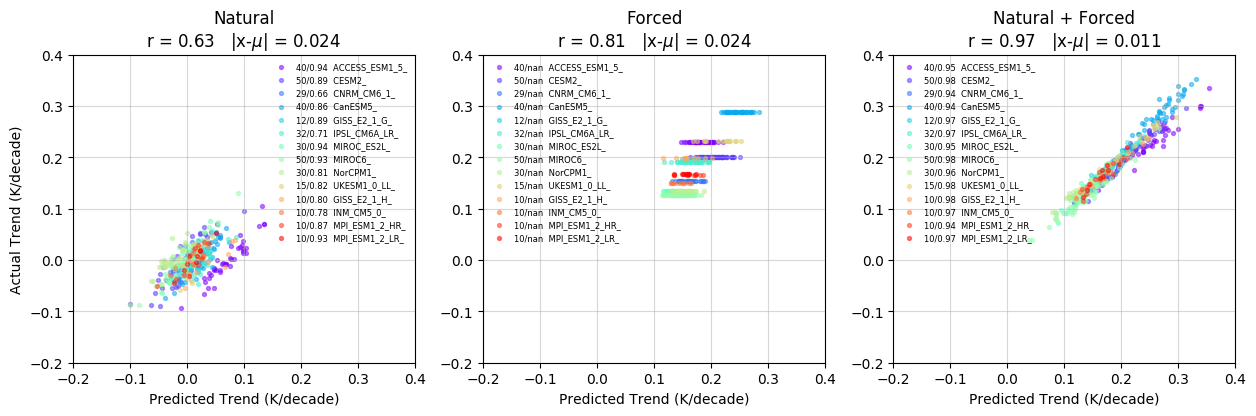

In [6]:
# CONV2d(16,3),Conv2d(16,1), maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.abs((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:5])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

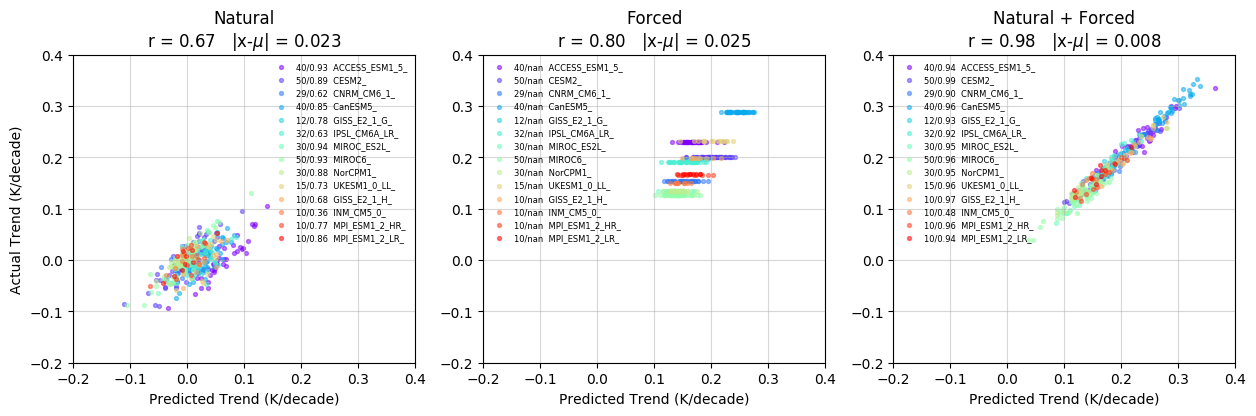

In [4]:
# CONV2d(16,3), maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.abs((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:5])